# Recommender System using MovieLens Dataset

In [1]:
#import required libraries
import re
import ast
import time
import heapq
import decimal
import operator
import subprocess
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import rpy2.robjects as ro
from itertools import islice
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from operator import itemgetter
from collections import OrderedDict
from networkx.algorithms import community
from rpy2.robjects.packages import importr
from sklearn.datasets import make_regression
from sklearn import datasets, linear_model,tree
from surprise.model_selection import cross_validate, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Reader, Dataset, SVD, evaluate, accuracy
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
%matplotlib inline

#### Begin loading all files - u.user, u.item, u.data into workable formats

In [2]:
#user profile
userCols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=userCols)
#users.head()

In [3]:
#movie profile with genres (full)
with open('./ml-100k/u.item') as content:
    mCols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url']
    genres = ['unknown', 'action', 'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 
          'film-noir',  'horror', 'musical', 'mystery', 'romance', 'sci-fi', 'thriller', 'war', 'western']
    mColsG = mCols + genres
    moviesG = pd.DataFrame(columns=mColsG)
    i = 0
    for x in content:
        x = x.split("|")
        x[-1] = x[-1][:-1]
        if x[1][-1] == ' ':
            x[1] = x[1][:-1]
        moviesG.loc[i] = [word if word!='' else "empty" for word in x]
        i = i + 1
moviesG['movie_id'] = moviesG['movie_id'].astype('int64')
moviesG[genres] = moviesG[genres].astype('int64')
#moviesG.head()

#### Begin data cleaning

Remove video_release_date since column values are empty

In [4]:
if 'video_release_date' in moviesG.columns:
    moviesG = moviesG.drop('video_release_date', axis=1)

#### End data cleaning

In [5]:
#movies profile with encoded genres
moviesGe = moviesG.copy()
encodedG = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's']
master = []
for i in range(0,len(moviesGe)):
    genre = []
    for column in moviesGe.columns[4:]: 
        if (moviesGe.iloc[i][column] == 1):
            genre.append(encodedG[moviesGe.columns.get_loc(column)-5])    
            #print(genre)
    master.append(genre)
moviesGe['encoded_genre'] = master
moviesGe['encoded_genre'] = moviesGe['encoded_genre'].astype('str')
moviesGe = moviesGe.drop(moviesGe.columns[list(range(4,23))], axis=1) 
#moviesGe.head()

In [6]:
#movies profile with '|' separated named genres
moviesGn = moviesG.copy()
named = []
for i in range(0,len(moviesGn)):
    genre = ""
    for column in moviesGn.columns[5:]: 
        if (moviesGn.iloc[i][column] == 1):
            genre = genre + column + '|'
    genre = genre[:-1]
    named.append(genre)
moviesGn['genre_names'] = named
moviesGn['genre_names'] = moviesGn['genre_names'].astype('str')
moviesGn = moviesGn.drop(moviesGn.columns[list(range(4,23))], axis=1) 
#moviesGn.head()

In [7]:
#user-movie profile
umCols = ['user_id', 'movie_id', 'rating', 'timestamp']
um = pd.read_csv('ml-100k/u.data', sep='\t', names=umCols)
#um.head()

#### End loading all files - u.user, u.item, u.data into workable formats

#### Begin creating workable DFs and dictionaries

In [8]:
#splitting multi-genre movies into multiple 'same' movies with single genre
new = ([(row['movie_id'], row['movie_title'], row['genre_names'].split('|'))              
                    for _, row in moviesGn.iterrows()])#.reset_index()
movCol = ['movie_id', 'movie_title', 'genre']
newdf = pd.DataFrame(columns=movCol)
i = 0
for num1 in range(0,len(new)-1):
    for num2 in range(0,len(new[num1][2])):
        newdf.loc[i, 'movie_id'] = new[num1][0]
        newdf.loc[i, 'movie_title'] = new[num1][1]
        newdf.loc[i, 'genre'] = new[num1][2][num2]
        i = i + 1
newdf.to_csv('./FINAL/data/movie_genre.txt', columns= ['movie_title', 'genre'] ,sep='\t',index=False,header=False,float_format='%.0f')
#newdf.head()

In [9]:
#forming movie - genre DF
newdff = newdf.copy()
newdff = newdff.drop('movie_id', axis=1)
#newdff.head()

In [10]:
#forming user_id - movie_id - rating - timestamp - movie_title.... DF
newer = um.merge(moviesGn, left_on='movie_id', right_on='movie_id', how='inner')
#newer.head()

In [11]:
#forming user_id - movie_id - rating - timestamp - movie_title - age - gender .... DF
rumerged = um.merge(users, left_on='user_id', right_on='user_id', how='inner')
#rumerged.head()

In [12]:
#forming movie_title - ratings DF
mrdf = newer.copy()
mrdf = mrdf.drop(mrdf.columns[0:2], axis=1)
mrdf = mrdf.drop(mrdf.columns[1:2], axis=1)
mrdf = mrdf.drop(mrdf.columns[2:], axis=1)
#mrdf.head()

In [13]:
#calculating movie: [all the ratings of that movie] file
mr_map = {}
#iterate over all movies
for keyval in mrdf['movie_title']:
    rat = []
    #iterate over all movies rated by a user
    if keyval in mr_map.keys():
        mr_map[keyval].append(mrdf.loc[mrdf['movie_title'] == keyval, 'rating'].iloc[len(mr_map[keyval])])
    else:
        rat.append(mrdf.loc[mrdf['movie_title'] == keyval, 'rating'].iloc[0])
        mr_map[keyval] = rat
#mr_map

In [14]:
#create movie - avg. rating dictionary
avgDict = {}
for k,v in mr_map.items():
    # v is the list of grades for student k
    avgDict[k] = sum(v)/ float(len(v))
#avgDict

In [15]:
#convert the above dictionary to a DF
avgDictdf = pd.DataFrame(columns=['movie_title', 'rating'])
index = 0
for k,v in avgDict.items():
    index = index + 1
    avgDictdf.loc[index, 'movie_title'] = k
    avgDictdf.loc[index, 'rating'] = v
#avgDictdf

In [16]:
avgDictdf.to_csv('./FINAL/data/movie_avg_rating.txt', columns= ['movie_title', 'rating'] ,sep='\t',index=False,header=False,float_format='%.0f',encoding='latin-1')

#### Begin data cleaning

Change timestamp to comprehendible DD-MM-YYYY form 

In [17]:
newer = newer[newer['movie_title'] != 'unknown']
newer = newer[newer['release_date'] != 'empty']
newer.to_csv('./FINAL/data/jlt/Fullnewer.txt', sep='\t',index=False,header=False,float_format='%.0f')
newer.to_csv('./FINAL/data/jlt/newer.txt', columns= ['user_id', 'movie_title'] ,sep='\t',index=False,header=False,float_format='%.0f')
ncols = ['user_id', 'movie_id', 'rating', 'timestamp', 'movie_title','release_date', 'imdb_url', 'genre_names']
newer = pd.read_csv('./FINAL/data/jlt/Fullnewer.txt', sep='\t', names=ncols, encoding='latin-1')

#### End data cleaning

#### Begin performing Content Based Recommendation (CBR)

Since we want to build personalised recommendation, we compute similarity between movies based on certain metrics. Then, we can safely deduce/predict the movies that the user will like based on movie previously liked by the user. This is done using the similarity metric which is based on the attributes/content of the movies. Hence, it's called Content Based Recommendation (CBR). We can build the CBR model based on either all or a subset of a movie's attributes.

Suppose, we build a CBR model with the movie name as one such attribute. For example, a movie 'Love Actually' and 'Love Story' would both fall into 'Romance' genre. Hence, based on the movie name, we can cluster similar named movies. However, this is NOT the best approach since it might also be misleading. For example, a movie 'Gone With The Wind' (Romance) might have nothing to do with 'Wind Chill' (Horror). We see this below.

In [18]:
#creating DF with movie names without year
cbr = moviesGn.copy()
cbr['movie_title'] = cbr['movie_title'].map(lambda x: str(x)[:-7])
#cbr

Here, we are using tf–idf or TFIDF (term frequency–inverse document frequency) approach of text mining to identify repetition of words in the movie names to recommend other movies having similar names to the given movie. Its value is proportional to the number of times a word appears in the document.

In [22]:
#using term frequency-inverse document frequency approach to for movie_name weighting
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
#returns T x D i.e. term document matrix
tfidf_matrix = tf.fit_transform(moviesG['movie_title'])

Using Cosine Similarity: to compute similarity between two movies. Mathematically, it is cosine(x,y)= x.(y⊺) / (||x||.||y||) .

In [23]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

Using this pairwise cosine similarity matrix for all the movies, we define a function that returns the topmost similar movies based on the cosine similarity score.

In [24]:
#this function gives us similar movies to a given movie based on text mining on movie_names
indices = pd.Series(cbr.index, index=cbr['movie_title'])
def get_similar(title):
    print("The genre of the given movie is:", cbr.loc[cbr['movie_title']==title,'genre_names'].iloc[0])
    idx = indices[title]
    sim_score = list(enumerate(cosine_sim[idx]))
    sim_score = sorted(sim_score, key=lambda x: x[1], reverse=True)
    sim_score = sim_score[1:11]#top10
    movie_indices = [i[0] for i in sim_score]
    for num in movie_indices:
        print(cbr['movie_title'].iloc[num],": ",cbr['genre_names'].iloc[num])

In [25]:
#getting a DF of indices of each movie with movie name as index
indices = pd.Series(cbr.index, index=cbr['movie_title'])

In [27]:
#predicting similar movies using CBR approach
get_similar('Toy Story')

The genre of the given movie is: animation|children|comedy
Pyromaniac's Love Story, A :  comedy|romance
Now and Then :  drama
Show, The :  documentary
To Have, or Not :  drama
Story of Xinghua, The :  drama
Philadelphia Story, The :  comedy|romance
NeverEnding Story III, The :  children|fantasy
FairyTale: A True Story :  children|drama|fantasy
Entertaining Angels: The Dorothy Day Story :  drama
Police Story 4: Project S (Chao ji ji hua) :  action


In [28]:
#predicting similar movies using CBR approach
get_similar('Love Serenade')

The genre of the given movie is: comedy
Love Is All There Is :  comedy|drama
Penny Serenade :  drama|romance
She's the One :  comedy|romance
Two Much :  comedy|romance
Before and After :  drama|mystery
A Chef in Love :  comedy
Pompatus of Love, The :  comedy|drama
Hotel de Love :  comedy|romance
Everyone Says I Love You :  comedy|musical|romance
In Love and War :  romance|war


#### End performing Content Based Recommendation (CBR)

#### Begin performing Collaborative Filtering (CF)

We see that the predictions are not so accurate since some genres differ by a lot. Hence, such a text mining approach would have been more useful, if we were given more details about the movies such as movie synopsis, cast, crew etc. This model doesn't give user-specific recommendations. Hence, to overcome this limitation arising due to limited descriptive data available in the MovieLens dataset, we compute user1's preference based on another similar user2's preference on the movies that the latter has reviewed but the former hasn't. This approach is called Collaborative Filtering (CF). We use Surprise library to implement CF.

In [32]:
#parsing a file containing user_id - movie_id - rating - timestamp
reader = Reader()
data = Dataset.load_from_df(um[['user_id', 'movie_id', 'rating']], reader)
#dividing the data into k-folds, here k=10
kf = KFold(n_splits=10)
#using SVD: matrix factorisation approach 
algo = SVD()

In [31]:
#performing training, testing and calculating RMSE
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.9374
RMSE: 0.9383
RMSE: 0.9320
RMSE: 0.9308
RMSE: 0.9286
RMSE: 0.9200
RMSE: 0.9343
RMSE: 0.9365
RMSE: 0.9173
RMSE: 0.9256


In [44]:
#predicting the rating for user_id = 10 and movie_id = 336
trainset = data.build_full_trainset()
algo.fit(trainset)
algo.predict(10, 336, 3)

Prediction(uid=10, iid=336, r_ui=3, est=3.1033947237688957, details={'was_impossible': False})

Here, we get a predicted rating of 3.10 for user_id = 10 and movie_id = 336. This CF approach of movie recommendation is independent of the content of the movie (like genres etc.) since the basis of its prediction is solely on how other similar users have rated the movie. However, this is also not the best way to approach the problem. So, we move on to actually making use of the attributes of each review for a movie by a user by performing feature engineering.

#### End performing Collaborative Filtering (CF)

#### Begin feature engineering

Here, we add a new feature: timeSinceRelease = timestamp - release_date. Other features like day of the week, month of the year can also be added.

In [45]:
#converting time columns into datetime format
newer['release_date'] = pd.to_datetime(newer['release_date'], format='%d-%b-%Y')
for i in range(0,len(newer)):
    newer.loc[i,'timestamp'] = datetime.fromtimestamp(newer.loc[i,'timestamp'])
newer['timestamp'] = pd.to_datetime(newer['timestamp'], format='%d-%b-%Y')

In [46]:
#creating a function to get the timespan between two datetime objects
def days_between(d1, d2):
    return abs((d1 - d2).days)

In [47]:
#creating timeSinceRelease column
ctr = 0
for i in newer['movie_title']:
    newer.loc[ctr,'timeSinceRelease'] = days_between(newer.loc[ctr,'timestamp'],newer.loc[ctr,'release_date'])
    ctr = ctr + 1

In [48]:
#creating dict out of this dataframe for all, min and max review release span of a movie 
all = {}
cnt = 0
for mov in newer['movie_title']:
    nummin = 0
    nummax = 0
    m = []
    if mov in all.keys():
        all[mov].append(newer.loc[newer['movie_title'] == mov, 'timeSinceRelease'].iloc[len(all[mov])])
    else:
        cnt = cnt + 1
        m.append(newer.loc[newer['movie_title'] == mov, 'timeSinceRelease'].iloc[0])
        all[mov] = m

In [49]:
#creating dictionary for timespan for each review of a movie
mindict = {}
maxdict = {}
spandict = {}

for ur in all.keys():
    #minh = []
    #maxh = []
    if ur in mindict.keys():
        continue
    #using min-heap and max-heap
    else:
        if all[ur] != []:
            minhh = all[ur]
            heapq.heapify(minhh)
            mindict[ur] = heapq.heappop(minhh)
    if ur in maxdict.keys():
        continue
    else:
        if all[ur] != []:
            maxhh = all[ur]
            heapq._heapify_max(maxhh)
            maxdict[ur] = heapq._heappop_max(maxhh)
    if ur in spandict.keys():
        continue
    else:
        if all[ur] != []:
            spandict[ur] = [maxdict[ur] - mindict[ur]]
#mindict
#maxdict
#spandict

In [50]:
#converting the above dictionary to a DF
timespan = pd.DataFrame.from_dict(spandict)
timespan = timespan.T
timespan.reset_index(level=0, inplace=True)
timespan.columns = ['movie_title', 'timespan']
#timespan

In [51]:
#saving the DF to file
timespan.to_csv('./FINAL/data/features/movie_timespan.txt',sep='\t',index=False,header=False,float_format='%.0f')

#### End feature engineering

In [52]:
#calculating users: [all the movies the user has rated] file
um_dict = {}
cnt = 0
for user in newer['user_id']:
    mov=[]
    if user in um_dict.keys():
        um_dict[user].append(newer.loc[newer['user_id'] == user, 'movie_title'].iloc[len(um_dict[user])])
    else:
        cnt = cnt + 1
        mov.append(newer.loc[newer['user_id'] == user, 'movie_title'].iloc[0])
        um_dict[user] = mov
#um_dict

In [53]:
#converting the above dict into DF
um_dictdf = pd.DataFrame(columns=['user_id', 'movie_title'])
index = 0
for k,v in um_dict.items():
    index = index + 1
    um_dictdf.loc[index, 'user_id'] = k
    um_dictdf.loc[index, 'movie_title'] = v
#um_dictdf

In [54]:
#saving the above DF to file
um_dictdf.to_csv('./FINAL/data/user_movies.txt', columns= ['user_id', 'movie_title'] ,sep='\t',index=False,header=False,float_format='%.0f')

In [55]:
#calculating users: [all the rating values by the user] file
ur_dict = {}
hold=0
for user in um['user_id']:
    mov=[]
    if user in ur_dict.keys():
        ur_dict[user].append(um.loc[um['user_id'] == user, 'rating'].iloc[len(ur_dict[user])])
    else:
        hold = hold+1
        mov.append(um.loc[um['user_id'] == user, 'rating'].iloc[0])
        ur_dict[user] = mov
#ur_dict

In [56]:
um1 = []
um1 = list(um_dict.keys())
um2 = []
um2 = list(um_dict.keys())

#### Begin performing graph computations

In [57]:
#calculating edge weights for weighted directed user movie graph
weighted_directed_user_movie_graph = open("./FINAL/data/wd_um_graph.txt", 'w')
p = 0
counter = 0
print("The total number of nodes in the graph: ",len(um_dict))
while p < len(um1):
    u1 = um1[p]
    u1m = um_dict[u1]
    #cos we don't to check for the same user with him/herself!
    q = p + 1 
    while q < len(um2):
        u2 = um2[q]
        u2m = um_dict[u2]
        overlap_movies = set(u1m) & set(u2m)
        #edge weight tells us what proportion of movies do two users have rated in common
        if len(overlap_movies) > 0:
            u1Ratio = decimal.Decimal(len(overlap_movies)) \
                / decimal.Decimal(len(u1m))
            u1Ratio = format(u1Ratio, '.3f')
            u2Ratio = decimal.Decimal(len(overlap_movies)) \
                / decimal.Decimal(len(u2m))
            u2Ratio = format(u2Ratio, '.3f')
            weighted_directed_user_movie_graph.write(u1.astype(str) + '\t' + u2.astype(str) + '\t' + str(u1Ratio) + '\n')
            weighted_directed_user_movie_graph.write(u2.astype(str) + '\t' + u1.astype(str) + '\t' + str(u2Ratio) + '\n')
            counter = counter + 1
        q = q + 1
    p = p + 1

The total number of nodes in the graph:  943


#### Call R script for weighted directed user network: WD_user

In [58]:
#calculating movie: [all the users that rated this movie] file
#iterate over all users
movie_map = {}
for keyval in um_dict.keys():
    #iterate over all movies rated by a user
    for movie in um_dict[keyval]:
        if (movie in movie_map):
            user_list = movie_map[movie]
            if keyval not in user_list:
                user_list.append(keyval)         
                movie_map[movie] = user_list
        else:
            movie_map[movie] = [keyval]

In [59]:
mov1 = []
mov1 = list(movie_map.keys())
mov2 = []
mov2 = list(movie_map.keys())

In [60]:
#calculating edge weights for weighted undirected movie user graph
weighted_undirected_movie_graph = open("./FINAL/data/wu_movie_graph.txt", 'w')
p = 0
counter = 0
print("The total number of nodes in the graph:",len(mov1))
while p < len(mov1):
    mov1_id = mov1[p]
    mov1_users = movie_map[mov1_id]
    q = p + 1
    while q < len(mov2):
        mov2_id = mov2[q]
        mov2_users = movie_map[mov2_id]
        overlap_actors = set(mov1_users) & set(mov2_users)
        if(len(overlap_actors) > 0):
            #calculating jaccard index as edge weight
            jaccard_index = decimal.Decimal(len(overlap_actors) * 100)/(decimal.Decimal(len(mov1_users) + len(mov2_users) - len(overlap_actors)))
            weighted_undirected_movie_graph.write(str(mov1_id) + "\t" + str(mov2_id) + "\t" + str(jaccard_index) + "\n")
            counter = counter + 1
        q = q + 1
    p = p + 1

The total number of nodes in the graph: 1663


#### End performing graph computations

#### Call R script for weighted undirected movie network: WU_movie

In [61]:
#creating user_id - pagerank dictionary
pg_reader = open("./FINAL/data/top943userpg.txt", "r")
page_rank = {}
for row in pg_reader.readlines():
    content = row.strip().split('\t')
    content[0] = content[0].strip('""')
    page_rank[content[0]] = float(ast.literal_eval(content[1]))

#getting list of all user_id numbers
u_id = []
for key in um_dict.keys():
    usr = key
    u_id.append(usr)

In [62]:
#building unordered set with unique user_id
page_rank = {int(k):float(v) for k, v in page_rank.items()}
u_id = np.ravel(np.ravel(np.array(u_id))) #flattened array
u_id = set(u_id)

In [63]:
#building movie - pageranks of users that rated that movie dictionary
output = {}
for key in um_dict.keys():
    usr = key
    mvs = um_dict[usr]
    pgval = page_rank[usr]
    for any in mvs:
        if any not in output:
            output[any] = []
        output[any].append(pgval)
#len(page_rank)
#len(output)

In [64]:
#checking number of pagerank values in movie - pageranks of users dictionary
nu = 0
for i in output.keys():
    nu = nu + len(output[i])
print("The total number of pg values are:", nu)
nuumin = 583
nuumax = 0
#length of pg values for each user- find max
for i in output.keys():
    if len(output[i]) < nuumin:
        nuumin = len(output[i])
    if len(output[i]) > nuumax:
        nuumax = len(output[i])
#might not be equal to number of users since one user could have rated more than one movie
print("The min number of pg values are:", nuumin)
print("The max number of pg values are:", nuumax)

The total number of pg values are: 99991
The min number of pg values are: 1
The max number of pg values are: 583


In [65]:
#creating output file with top 5 pageranks of each movie
ouputFile = open('./FINAL/data/features/movie_pageranks_top5.txt',"w")
for movie in output.keys():
    pagerankVal = output[movie]
    pagerankVal.sort(reverse=True)
    strPgRnk =""
    for val in range(0,5):#specifies number of (top) pagerank values to be taken (since sorted in decreasing order)
        if(val< len(pagerankVal)):
            y = pagerankVal[val]
            strPgRnk = strPgRnk+str(y)+"\t"
        else:
            strPgRnk = strPgRnk+"0"+"\t"
    final = movie+"\t"+strPgRnk+"\n"
    ouputFile.write(final)

In [66]:
#saving to file
ratings = pd.read_csv('./FINAL/data/movie_avg_rating_processed.txt', sep='\t', names=['movie_title','rating'],encoding='latin-1')
ratings = ratings.drop(ratings.index[0])
#ratings

In [67]:
#creating movie - avg. rating dictionary
mrate = {}
for val in range(1,len(ratings)):
    mrate[ratings.loc[val,'movie_title']] = ratings.loc[val,'rating']
#mrate

In [68]:
#converting the above dict to DF
mrate_df = pd.DataFrame(list(mrate.items()), columns=['movie_title', 'rating'])
#mrate_df

In [69]:
#sorting movies by rating in descending order
d_sorted_by_value = OrderedDict(sorted(mrate.items(), key=lambda x: x[1], reverse=True))
#d_sorted_by_value

In [70]:
#getting top 100 movies in terms of avg. rating
top100 = dict(islice(d_sorted_by_value.items(), 100))
top100_movies = top100.keys()
#top100

In [71]:
#creating user - avg. rating by the user for all its movies dictionary
for key in mrate.keys():
    mrate[key] = float(mrate[key])

user_rating = {}
i = 0
for u in um_dict.keys():
    #print i
    v = []
    for m in um_dict[u]:
        if m in mrate.keys():
            v.append(mrate[m])
    user_rating[u] = sum(v)/len(v)
    i += 1
#user_rating

In [72]:
#creating movie - avg. rating by all the users that have reviewed that movie dictionary
movie_to_actor_rating = {}
i = 0
for m in mrate.keys():
    v = []
    for u in movie_map[m]:
        v.append(float(user_rating[u]))#a[1:-1]]))
    movie_to_actor_rating[m] = sorted(v,reverse=True)#[:5]
    i += 1
#movie_to_actor_rating

In [73]:
#creatig a movie - timespan dictionary 
md_reader = open('./FINAL/data/features/movie_timespan.txt', 'r')

movies_timespan = {}
movies = []
tsp = []
i = 1
for md in md_reader:
    content = md.strip().split("\t")
    for x in content:
        movies.append(content[0])
        tsp.append(content[1])
    i += 1
movies_tsp = dict(zip(movies, tsp))
#movies_tsp

In [74]:
#converting the above dict to DF
tsp_df = pd.DataFrame(list(movies_tsp.items()), columns=['movie_title', 'timespan'])
#tsp_df

In [75]:
#creating DF with top 5 pageranks for users that rated that movie
df = pd.read_csv('./FINAL/data/movie_pageranks.txt', sep="\t", encoding='latin-1',header = None, names = ['movie_title','pg1','pg2','pg3','pg4','pg5','pg6','rating'])#,'Timespan'])
df['rating'] = 0
fdf = tsp_df.merge(df, left_on='movie_title', right_on='movie_title', how='inner')

In [76]:
#converting timespan to integer type
fdf['timespan'] = fdf['timespan'].astype('int64')
fdf = fdf.drop(fdf.columns[7], axis=1) #dropping pg6 since empty
#fdf

In [77]:
#filling up rating column of fdf
tsps = []
movies = []
nrows = fdf.shape[0]
for i in range(0,nrows):
    movie = df.iloc[i,0]
    if movie in mrate:
        #print("yo")
        fdf.iloc[i,7] = mrate[movie]
#fdf.info()

In [78]:
#dropping NA values in fdf
fdf = fdf.dropna() 
#fdf

The baseline model is trained on- age, gender, occupation, genres. Since gender and occupation are categorical features, they are one-hot encoded below.

In [79]:
#preparing base feature DF
mrgr = um.merge(moviesG, left_on='movie_id', right_on='movie_id', how='inner')
mergedd = mrgr.merge(users, left_on='user_id', right_on='user_id', how='inner')
rqdc = ['user_id','movie_title','age','occupation','gender']+genres#+['rating']
bline = mergedd[rqdc]
#keeping non-empty values
bline = bline[bline['gender'] != 'empty']
bline = bline[bline['occupation'] != 'empty']
#using one-hot encoding for categorical features like gender(M/F), occupation
bline['occupation'] = bline['occupation'].astype('category')
bline['gender'] = bline['gender'].astype('category')
one_hot_occ = bline.occupation.str.get_dummies()
bline = bline.drop('occupation',axis=1)
bline = bline.join(one_hot_occ,how='inner')
one_hot_g = bline.gender.str.get_dummies()
bline = bline.drop('gender',axis=1)
bline = bline.join(one_hot_g,how='inner')
bbline = bline.merge(avgDictdf, left_on='movie_title', right_on='movie_title', how='inner')
bbline = bbline.drop('user_id',axis=1)
#bline

The new features that are added are: 
1. timespan between movie release and review date
2. pageranks of the top 5 users that have rated that movie

In [80]:
#preparing feature DF including engineered features
fdf = fdf.drop('rating',axis=1)
fdff = fdf.merge(bbline, left_on='movie_title', right_on='movie_title', how='inner') 

In [81]:
#splitting into test and train data
X = fdff.iloc[:,1:50]#:,1:50]#0:len(fdf),1:7]
y = fdff.iloc[:,50:]#:,50:]#0:len(fdf),7:]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
test_size=0.20, random_state=0)

In [82]:
############################## Baseline Modelling (without engineered features) #################################
xb_train = bbline.iloc[0:1000,1:44]
yb_train = bbline.iloc[0:1000,44:]
rcl = tree.DecisionTreeRegressor()
rclf = rcl.fit(xb_train, yb_train)
for i in range(1, len(bbline)):
    movie = bbline.iloc[i, 0]
    if(movie == 'Little Buddha (1993)'):
        mov1_feature = bbline.iloc[i,1:44]
    if(movie == 'Little Big League (1994)'):
        mov2_feature = bbline.iloc[i,1:44]
    if (movie == 'Metro (1997)'):
        mov3_feature = bbline.iloc[i, 1:44]
#predicting rating for some movies
print("prediction for Little Buddha (1993)")
print(rclf.predict([mov1_feature]))
print("prediction for Little Big League (1994)")
print(rclf.predict([mov2_feature]))
print("prediction for Metro (1997)")
print(rclf.predict([mov3_feature]))

prediction for Little Buddha (1993)
[ 3.99145299]
prediction for Little Big League (1994)
[ 3.5532394]
prediction for Metro (1997)
[ 3.74587459]


In [135]:
#getting accuracy scores
print("score: ",(model.score(X_train, y_train)))
print("\n")

score:  0.346443585594




In [102]:
############################## Linear Regression #################################
regr = linear_model.LinearRegression()
model = regr.fit(X_train, y_train)
for i in range(1, len(fdff)):
    movie = fdff.iloc[i, 0]
    if(movie == 'Little Buddha (1993)'):
        mov1_feature = fdff.iloc[i,1:50]
    if(movie == 'Little Big League (1994)'):
        mov2_feature = fdff.iloc[i,1:50]
    if (movie == 'Metro (1997)'):
        mov3_feature = fdff.iloc[i, 1:50]

#predicting rating for same set of movies
print("prediction for Little Buddha (1993)")
print(regr.predict([mov1_feature]))
print("prediction for Little Big League (1994)")
print(regr.predict([mov2_feature]))
print("prediction for Metro (1997)")
print(regr.predict([mov3_feature]))
print("\n")

prediction for Little Buddha (1993)
[[ 3.43663628]]
prediction for Little Big League (1994)
[[ 2.5772907]]
prediction for Metro (1997)
[[ 3.16664091]]




Text(0.5,1,'Linear Regression Model')

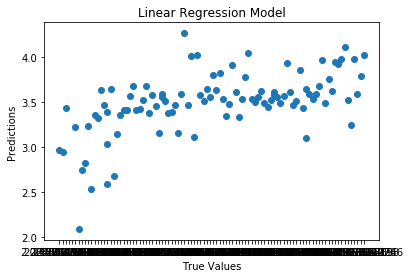

In [127]:
#plotting true values v/s predictions of linear regression (top 100 values)
predictions = regr.predict(X_test)
plt.scatter(y_test[0:100], predictions[0:100])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Linear Regression Model')

In [121]:
#performing 10-fold CV and getting accuracy scores
lr_scores = cross_val_score(model, X_train, y_train, cv = 10)
print("cross validation scores: \n",lr_scores)
print("score without cv: {}".format(model.score(X_train, y_train)))
print("\n")

cross validation scores: 
 [ 0.34028047  0.37086327  0.31849793  0.32726282  0.34128561  0.33365316
  0.36486928  0.34915655  0.3538425   0.35127401]
score without cv: 0.3464435855937428




In [128]:
############################## Decision Tree #################################
dtr = tree.DecisionTreeRegressor()
dtm = dtr.fit(X_train, y_train)
for i in range(1, len(fdff)):
    movie = fdff.iloc[i, 0]
    if(movie == 'Little Buddha (1993)'):
        mov1_feature = fdff.iloc[i,1:50]
    if(movie == 'Little Big League (1994)'):
        mov2_feature = fdff.iloc[i,1:50]
    if (movie == 'Metro (1997)'):
        mov3_feature = fdff.iloc[i, 1:50]

#predicting rating for same set of movies
print("prediction for Little Buddha (1993)")
print(dtr.predict([mov1_feature]))
print("prediction for Little Big League (1994)")
print(dtr.predict([mov2_feature]))
print("prediction for Metro (1997)")
print(dtr.predict([mov3_feature]))
print("\n")

prediction for Little Buddha (1993)
[ 3.31818182]
prediction for Little Big League (1994)
[ 2.875]
prediction for Metro (1997)
[ 2.91666667]




In [129]:
#performing 10-fold CV and getting accuracy scores
dt_scores = cross_val_score(dtm, X_train, y_train, cv = 10)
print("cross validation scores: \n",dt_scores)
print("score without cv: {}".format(dtm.score(X_train, y_train)))
print("\n")

cross validation scores: 
 [ 0.95904142  0.95993954  0.96006499  0.95271631  0.96080743  0.95839962
  0.95652143  0.95568772  0.9603449   0.95416337]
score without cv: 0.9886007071924332




Above, we see that the Decision Tree model performs better than the Linear Regression model. It has higher cross validation scores and gives accurate prediction for the ratings of the three movies taken above (with their actual average ratings being very close to the predictions by the DT model). In comparison to the baseline model, both LR and DT have done a good job in predicting the movie ratings and that feature engineering has been useful in bumping up the accuracy from 36.4% to about 98% after cross-validation using the DT model.